<a href="https://colab.research.google.com/github/SLCFLAB/Data-Science-Python/blob/main/Day%2015/15_2.%20NLP_Transformer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: 서울대학교 신효필 교수님의 텍스트 및 자연어 빅데이터 분석 방법론 2021-2학기 강의에서 발췌된 내용을 포함합니다.

https://hpshin.github.io/NaturalLanguageBigDataAnalysis/index.html


In [1]:
# 트랜스포머 설치
! pip install transformers datasets
# 최신버전 설치는 아래 커맨드 참고
# ! pip install git+https://github.com/huggingface/transformers.git

     |████████████████████████████████| 4.0 MB 24.8 MB/s 
     |████████████████████████████████| 325 kB 29.1 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 880 kB 51.7 MB/s 
     |████████████████████████████████| 6.6 MB 31.4 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 136 kB 42.0 MB/s 
     |████████████████████████████████| 212 kB 47.6 MB/s 
     |████████████████████████████████| 1.1 MB 17.2 MB/s 
     |████████████████████████████████| 127 kB 18.1 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 16.9 MB/s 
     |████████████████████████████████| 144 kB 43.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=14f390c0a080bfd9b68427e4cda23d10b892688859b6e4771b3d4c4f924a217b
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d6602

# Project

### **1. 시퀀스 분류(https://huggingface.co/transformers/v2.10.0/usage.html)**

In [ ]:
!pip install transformers keras tensorflow

In [ ]:
# 감정 분석 파이프라인 설정 
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")

classes = ["not paraphrase", "is paraphrase"]

sequence_0 = "The company HuggingFace is based in New York City" # 문자열_0: "회사 허깅페이스는 뉴욕 도시에 위치해 있다.""

sequence_1 = "Apples are especially bad for your health" # 문자열_1 "사과는 특히 당신의 건강에 좋지 않다."

sequence_2 = "HuggingFace's headquarters are situated in Manhattan" # 문자열_2"허깅페이스 사의 본부는 맨하탄에 위치해있다."

# The tokenizer will automatically add any model specific separators (i.e. <CLS> and <SEP>) and tokens to
# the sequence, as well as compute the attention masks.
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt") # 문자열_0과 문자열_2간의 패러프레이징 확률을 계산 

not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt") # 문자열_0과 문자열_1간의 패러프레이징 확률을 계산 



paraphrase_classification_logits = model(**paraphrase).logits # 문자열_0과 문자열_2간의 패러프레이징 확률을 로짓 함수값으로 계산 

not_paraphrase_classification_logits = model(**not_paraphrase).logits # 문자열_0과 문자열_1간의 패러프레이징 확률을 로짓 함수값으로 계산 



paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0] # 문자열_0과 문자열_2간의 패러프레이징 확률 결과값 도출

not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0] # 문자열_0과 문자열_1간의 패러프레이징 확률 결과값 도출

# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")

# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


In [ ]:
# 모듈 불러오기
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [ ]:
# 네이버 영화 리뷰 감정분석 데이터 다운로드하기 
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
# Pandas로 트레이닝셋과 테스트셋 데이터 로드하기 
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


In [ ]:
# 트레이닝셋 확인 (긍정은 1, 부정은 0)
train.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 리뷰 문장 추출하기 
sentences = train['document']
sentences[:5]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

In [ ]:
# BERT의 입력 형태로 변화하기 
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:5]

['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]',
 '[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]',
 '[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]',
 '[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]',
 '[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]']

![BERT](https://camo.githubusercontent.com/ea435ce1eed653db0b7412bbe87285a8ae976176/68747470733a2f2f6d696e6f2d7061726b372e6769746875622e696f2f696d616765732f323031392f30322f626572742d696e7075742d726570726573656e746174696f6e2e706e67)

In [ ]:
# 라벨 및 라벨 개수 확인하기 
labels = train['label'].values
print(labels)
print(len(labels))

[0 1 0 ... 0 1 0]
150000


In [ ]:
# BERT의 토크나이저 활용하기 
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 토크나이저에 따라 구분하기
print (sentences[0])
print (tokenized_texts[0])

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]
['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]']


In [ ]:
# 입력 토큰의 최대 시퀀스 길이 설정하기
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환하기 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 최대 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# 훈련셋과 검증셋으로 분리하기 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리하기 
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환하기
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

# 텐서값 출력하기 
print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9711,  11489,   9364,  41850,   9004,  32537,   9491,  35506,
         17360,  48549,    119,    119,   9477,  26444,  12692,   9665,  21789,
         11287,   9708, 119235,   9659,  22458, 119136,  12965,  48549,    119,
           119,   9532,  22879,   9685,  16985,  14523,  48549,    119,    119,
          9596, 118728,    119,    119,   9178, 106065, 118916,    119,    119,
          8903,  11664,  11513,   9960,  14423,  25503, 118671,  48549,    119,
           119,  21890,   9546,  37819,  22879,   9356,  14867,   9715, 119230,
        118716,  48345,    119,   9663,  23321,  10954,   9638,  35506, 106320,
         10739,  20173,   9359,  19105,  11102,  42428,  17196,  48549,    119,
           119,    100,    117,   9947,  12945,   9532,  25503,   8932,  14423,
         35506, 119050,  11903,  14867,  10003,  14863,  33188,  48345,    119,
           102,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 데이터 로더로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
# 데이터셋 구분 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### **1.1.전처리 - 테스트셋**

In [ ]:
# 리뷰 문장 추출하기 
sentences = test['document']
sentences[:5]

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4    3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
Name: document, dtype: object

In [ ]:
# BERT의 입력 형식에 맞게 변환하기 
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:5]

['[CLS] 굳 ㅋ [SEP]',
 '[CLS] GDNTOPCLASSINTHECLUB [SEP]',
 '[CLS] 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 [SEP]',
 '[CLS] 지루하지는 않은데 완전 막장임... 돈주고 보기에는.... [SEP]',
 '[CLS] 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠?? [SEP]']

In [ ]:
# 라벨 및 라벨 개수 확인
labels = test['label'].values
print(labels)
print(len(labels))

[1 0 0 ... 0 0 0]
50000


In [ ]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 문장 확인하기 
print (sentences[0])
print (tokenized_texts[0])

[CLS] 굳 ㅋ [SEP]
['[CLS]', '굳', '[UNK]', '[SEP]']


In [ ]:
# 입력 토큰의 최대 시퀀스 길이 설정하기
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환하기 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [ ]:

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 텐서값 확인하기
print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor(1)
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### **1.2.모델 생성**

In [ ]:
# 디바이스(CPU, GPU) 설정하기 및 확인하기 
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
# 분류를 위한 BERT 모델 생성하기 
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

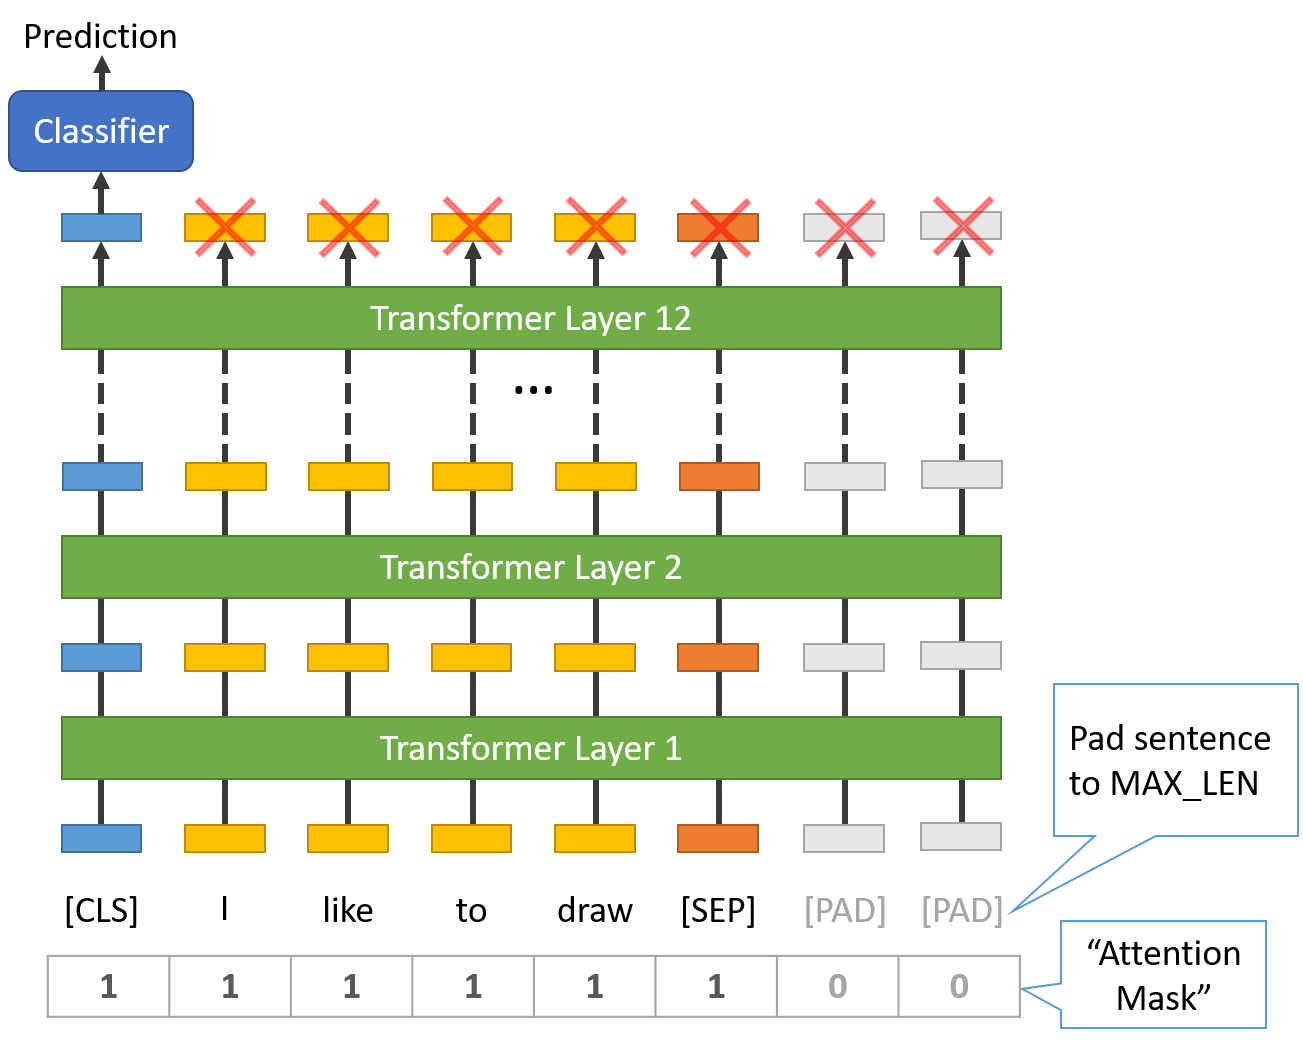

In [ ]:
# 옵티마이저 설정하기
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에포크 횟수 정하기(시간 관계상 2번으로 설정)
epochs = 2

# 총 훈련 스텝 정하기 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 초반에 학습률을 조금씩 변화시키는 스케줄러 생성하기 
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### **1.3.모델 학습**

In [ ]:
# 정확도 계산 함수 정의하기 
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 시간 표시 함수 정의하기
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # 시:분:초로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 재현을 위해 랜덤시드 고정하기
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화하기
model.zero_grad()

# 에포크만큼 반복하기 
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정하기
    t0 = time.time()

    # 로스 초기화하기
    total_loss = 0

    # 훈련모드로 변경하기 
    model.train()
        
    # 데이터로더에서 배치 수만큼 반복하여 가져오기 
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시하기
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣기
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출하기
        b_input_ids, b_input_mask, b_labels = batch

        # 순전파 수행하기                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 손실함수값 구하기
        loss = outputs[0]

        # 총 손실함수값 계산하기
        total_loss += loss.item()

        # 역전파 수행으로 그래디언트 계산하기
        loss.backward()

        # 그래디언트 클리핑(기울기 폭발에 대한 대책으로 기울기의 L2노름 값이 일정 기준을 초과하면 기울기를 수정하는 방식) 설정
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치의 매개값 갱신하기
        optimizer.step()

        # 스케줄러로 학습률 감소시키기
        scheduler.step()

        # 그래디언트 초기화하기
        model.zero_grad()

    # 평균 손실함수값 계산하기 
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정하기
    t0 = time.time()

    # 평가모드로 변경하기
    model.eval()

    # 변수 초기화하기
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣기
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출하기
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산하지 않기 
        with torch.no_grad():     
            # 순전파 수행하기
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 손실함수값 구하기
        logits = outputs[0]

        # CPU로 데이터 이동시키기 
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력된 로짓값과 라벨을 비교하여 정확도 계산하기 
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    # 정확도 출력하기
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

# 마감 메시지 출력하기
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:10:23.
  Batch 1,000  of  4,219.    Elapsed: 0:20:50.
  Batch 1,500  of  4,219.    Elapsed: 0:31:18.
  Batch 2,000  of  4,219.    Elapsed: 0:41:40.
  Batch 2,500  of  4,219.    Elapsed: 0:52:00.
  Batch 3,000  of  4,219.    Elapsed: 1:02:20.
  Batch 3,500  of  4,219.    Elapsed: 1:12:39.
  Batch 4,000  of  4,219.    Elapsed: 1:23:00.

  Average training loss: 0.38
  Training epcoh took: 1:27:33

Running Validation...
  Accuracy: 0.85
  Validation took: 0:03:25

======== Epoch 2 / 2 ========
Training...
  Batch   500  of  4,219.    Elapsed: 0:10:19.
  Batch 1,000  of  4,219.    Elapsed: 0:20:38.
  Batch 1,500  of  4,219.    Elapsed: 0:30:58.
  Batch 2,000  of  4,219.    Elapsed: 0:41:17.
  Batch 2,500  of  4,219.    Elapsed: 0:51:35.
  Batch 3,000  of  4,219.    Elapsed: 1:01:54.
  Batch 3,500  of  4,219.    Elapsed: 1:12:12.
  Batch 4,000  of  4,219.    Elapsed: 1:22:30.

  Average training loss: 0.28
  

### **1.4.새로운 문장 평가**

In [ ]:
# 입력 데이터 변환하기
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰 단위로 분리하기
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이 설정하기
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환하기 
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화하기 
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않으므로 속도 향상시키기 
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환하기 
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    # 입력값과 마스크 출력하기 
    return inputs, masks

In [ ]:
# 문장 테스트하기
def test_sentences(sentences):

    # 평가모드로 변경하기
    model.eval()

    # 문장을 입력 데이터로 변환하기
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣기
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 중지하기
    with torch.no_grad():     
        # 순전파 수행하기
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 손실함수값 구하기
    logits = outputs[0]

    # CPU로 데이터 이동하기
    logits = logits.detach().cpu().numpy()

    # 로짓값 구하기 
    return logits

In [ ]:
# 실제 사례에 대한 결과값 출력하기1
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))

[[ 0.5292857 -0.594953 ]]
0


In [ ]:
# 실제 사례에 대한 결과값 출력하기2
logits = test_sentences(['주연배우가 아깝다. 총체적 난국...'])

print(logits)
print(np.argmax(logits))

[[ 3.0603206 -3.0913913]]
0


### **2. Q&A 예시**

In [ ]:
# 모듈 설치하기 
!pip install torch==1.5.0+cu92 torchvision==0.6.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7 MB 6.3 kB/s 
     |████████████████████████████████| 6.5 MB 45.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu92 which is incompatible.


In [ ]:
# 모듈 불러오기
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# 프리트레인된 토크나이저와 모델 불러오기
tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2") 
model = AutoModelForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2", return_dict=False)

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

In [ ]:
# 질문 제시하기 ("누가 마케도니아를 다스렸는가")
question = "Who ruled Macedonia"

# 문맥 제시하기 (마케도니아에 대한 설명으로서 역사와 통치 군주, 위치 등에 대해서 다루고 있음)
context = """Macedonia was an ancient kingdom on the periphery of Archaic and Classical Greece, 
and later the dominant state of Hellenistic Greece. The kingdom was founded and initially ruled 
by the Argead dynasty, followed by the Antipatrid and Antigonid dynasties. Home to the ancient 
Macedonians, it originated on the northeastern part of the Greek peninsula. Before the 4th 
century BC, it was a small kingdom outside of the area dominated by the city-states of Athens, 
Sparta and Thebes, and briefly subordinate to Achaemenid Persia."""


# 1. 입력값 토크나이징하기 
# 주의: return_tensors='pt'형태를 포함하지 않는다면 리스트 탐색은 쉬워지지만 모델에 피드를 줄 수 없게 됨
inputs = tokenizer.encode_plus(question, context, return_tensors="pt") 

# 2. 모델 점수 확보하기 
answer_start_scores, answer_end_scores = model(**inputs)
answer_start = torch.argmax(answer_start_scores)  # 최대 점수값과 함께 가장 답변의 시작부분일 것 같은 부분을 얻어내기
answer_end = torch.argmax(answer_end_scores) + 1  # 최대 점수값과 함께 가장 답변의 끝 부분일 것 같은 부분을 얻어내기

# 3. 답변의 범위 구하기 
# 확률상 시작과 끝에 해당할 가능성이 가장 높은 토큰을 얻게 되면, 그 사이에 있는 모든 토큰을 포함하는 방식으로 이 때 토큰들을 다시 문자로 변환함
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))

'the Argead dynasty'

In [ ]:
# 위키피디아 모듈 설치하기
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=651fda7bf0828c504ff67641ddb418fa7baacd7591bb8fab1fcdca7523d6ac75
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [ ]:
# 모듈 불러오기
import wikipedia as wiki
import torch
from collections import OrderedDict
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# 클래스 정의하기 
class DocumentReader:
    def __init__(self, pretrained_model_name_or_path='bert-large-uncased'):
        self.READER_PATH = pretrained_model_name_or_path
        self.tokenizer = AutoTokenizer.from_pretrained(self.READER_PATH) # 토크나이저 설정 
        self.model = AutoModelForQuestionAnswering.from_pretrained(self.READER_PATH, return_dict=False) # 모델 설정 
        self.max_len = self.model.config.max_position_embeddings # 최장 길이 설정 
        self.chunked = False #청킹화 아님 상태로 설정 

    # 토크나이저 정의 
    def tokenize(self, question, text):
        self.inputs = self.tokenizer.encode_plus(question, text, add_special_tokens=True, return_tensors="pt")
        self.input_ids = self.inputs["input_ids"].tolist()[0]

        # 입력값이 길이가 입력 최대한도를 넘으면 이를 청킹화시키고 표시하기 
        if len(self.input_ids) > self.max_len:
            self.inputs = self.chunkify()
            self.chunked = True

    # 청킹화하는 함수 정의 
    def chunkify(self):
        """ 
        트랜스포머 모델의 입력값의 최대한도 안에 들어갈 수 있도록 긴 글을 쪼개는 함수이며, BERT와 RoBERTa, ALBERT는 아래와 같은 형태로 입력할 필요가 있음
        [CLS] question tokens [SEP] context tokens [SEP].
        """

        # 토큰의 타입 인덱스값에 따른 질문 마스크 생성하기(0은 질문 토큰,1은 문맥 토큰)
        
        qmask = self.inputs['token_type_ids'].lt(1)
        qt = torch.masked_select(self.inputs['input_ids'], qmask)
        chunk_size = self.max_len - qt.size()[0] - 1 # "-1"은 마지막에 종결하는 [SEP]를 더하는 것을 나타내기 위함

        # 사전 형태의 사전을 만드는데 모든 하위 사전은 청킹화되기 이전의 모델 입력값의 구조를 모방함
        chunked_input = OrderedDict()
        for k,v in self.inputs.items():
            q = torch.masked_select(v, qmask)
            c = torch.masked_select(v, ~qmask)
            chunks = torch.split(c, chunk_size)
            
            for i, chunk in enumerate(chunks):
                if i not in chunked_input:
                    chunked_input[i] = {}

                thing = torch.cat((q, chunk))
                if i != len(chunks)-1:
                    if k == 'input_ids':
                        thing = torch.cat((thing, torch.tensor([102])))
                    else:
                        thing = torch.cat((thing, torch.tensor([1])))

                chunked_input[i][k] = torch.unsqueeze(thing, dim=0)
        return chunked_input


    # 정답 함수 구현하기 
    def get_answer(self):
        if self.chunked:
            answer = ''
            for k, chunk in self.inputs.items():
                answer_start_scores, answer_end_scores = self.model(**chunk)

                answer_start = torch.argmax(answer_start_scores)
                answer_end = torch.argmax(answer_end_scores) + 1

                ans = self.convert_ids_to_string(chunk['input_ids'][0][answer_start:answer_end])
                if ans != '[CLS]':
                    answer += ans + " / "
            return answer
        else:
            answer_start_scores, answer_end_scores = self.model(**self.inputs)

            answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
            answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
        
            return self.convert_ids_to_string(self.inputs['input_ids'][0][
                                              answer_start:answer_end])
    # 인덱스를 문자로 변환하는 함수 정의하기 
    def convert_ids_to_string(self, input_ids):
        return self.tokenizer.convert_tokens_to_string(self.tokenizer.convert_ids_to_tokens(input_ids))

In [ ]:
# # collapse-hide 

# 결과값을 보다 읽기 쉽게 하기 위해서 토큰 문자열의 길이에 대한 주의사항을 끄기 
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [ ]:
# 질문 설정하기
questions = [
    'When was Bill Clinton born?',
    'Why is the sky blue?',
    'How many sides does a pentagon have?'
]

# 리더기 설정하기 
reader = DocumentReader("deepset/bert-base-cased-squad2") 


# 질문, 위키피디아 모듈에서의 페이지 결과값, 그리고 그에 대한 답을 출력하기 
for question in questions:
    print(f"Question: {question}")
    results = wiki.search(question)

    page = wiki.page(results[0])
    print(f"Top wiki result: {page}")

    text = page.content

    reader.tokenize(question, text)
    print(f"Answer: {reader.get_answer()}")
    print()

Question: When was Bill Clinton born?
Top wiki result: <WikipediaPage 'Bill Clinton'>


Token indices sequence length is longer than the specified maximum sequence length for this model (17543 > 512). Running this sequence through the model will result in indexing errors


Answer: 1946 / 

Question: Why is the sky blue?
Top wiki result: <WikipediaPage 'Diffuse sky radiation'>
Answer: Rayleigh scattering /  / 

Question: How many sides does a pentagon have?
Top wiki result: <WikipediaPage 'The Pentagon'>
Answer: five / 



## **3-1. 예시**

In [ ]:
# 파이프라인 설정하기
import transformers
from transformers import pipeline
unmasker = pipeline("fill-mask")

No model was supplied, defaulted to distilroberta-base (https://huggingface.co/distilroberta-base)


In [ ]:
# 매스킹된 예시문장 제시하기 
from pprint import pprint
pprint(unmasker(f"HuggingFace is creating a {unmasker.tokenizer.mask_token} that the community uses to solve NLP tasks."))

[{'score': 0.17927499115467072,
  'sequence': 'HuggingFace is creating a tool that the community uses to solve '
              'NLP tasks.',
  'token': 3944,
  'token_str': ' tool'},
 {'score': 0.11349404603242874,
  'sequence': 'HuggingFace is creating a framework that the community uses to '
              'solve NLP tasks.',
  'token': 7208,
  'token_str': ' framework'},
 {'score': 0.05243541672825813,
  'sequence': 'HuggingFace is creating a library that the community uses to '
              'solve NLP tasks.',
  'token': 5560,
  'token_str': ' library'},
 {'score': 0.034935448318719864,
  'sequence': 'HuggingFace is creating a database that the community uses to '
              'solve NLP tasks.',
  'token': 8503,
  'token_str': ' database'},
 {'score': 0.028602484613656998,
  'sequence': 'HuggingFace is creating a prototype that the community uses to '
              'solve NLP tasks.',
  'token': 17715,
  'token_str': ' prototype'}]


In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer 
import torch

# 토크나이저와 모델 불러오기
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-cased")

# 시퀀스 제시하기
sequence = "Distilled models are smaller than the models they mimic. Using them instead of the large " \
    f"versions would help {tokenizer.mask_token} our carbon footprint."

# 토크나이징하고 토큰 인덱스에 매스킹하기 
inputs = tokenizer(sequence, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

# 토큰의 로짓값 구하고 매스킹하기 
token_logits = model(**inputs).logits
mask_token_logits = token_logits[0, mask_token_index, :]

# 최고 다섯개의 로짓값 구하기 
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

Distilled models are smaller than the models they mimic. Using them instead of the large versions would help reduce our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help increase our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help decrease our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help offset our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help improve our carbon footprint.


## **3-2. 예시**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, top_k_top_p_filtering
import torch
from torch.nn import functional as F

# GPT-2 토크나이저와 모델 불러오기 
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2')

# 입력값 구문 토크나이징하기 
phrase = f'Make sure to read the rest of this'
inputs = tokenizer.encode(phrase, return_tensors='pt')

# 마지막 층에서 로짓값 얻기 
last_layer_logits = model(inputs).logits[:, -1, :]

# 30개의 최대 로짓값을 최고로 유지하되 총 확률값이 1과 같거나 넘을 경우 중단하기
top_logits = top_k_top_p_filtering(last_layer_logits, top_k=100, top_p=1.0)

# 로짓값을 소프트맥스 함수로 확률값으로 변환시키기 
probabilities = F.softmax(top_logits, dim=-1)

# 다음번 토큰 생성하기 
generated_next_token = torch.multinomial(probabilities, num_samples=2)
generated = torch.cat([inputs, generated_next_token], dim=-1)

# 결과값 얻기 
result_string = tokenizer.decode(generated.tolist()[0])

# 문자열 출력하기
print(result_string)

Make sure to read the rest of this post paragraph
